## Importando librerías

In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

## Cargando dataset

In [12]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [44]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

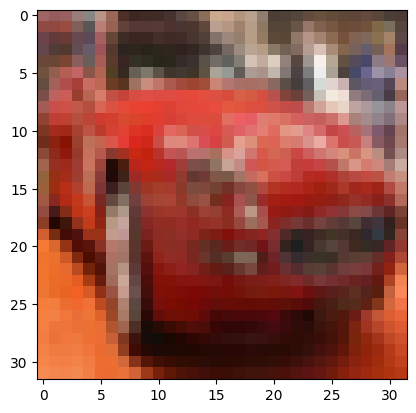

In [45]:
plt.imshow(x_train[5])

## Limpieza de datos

In [46]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [47]:
num_clases = len(np.unique(y_train))
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)

In [48]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### Normalization

In [49]:
mean = np.mean(x_train)
std = np.std(x_train)

In [50]:
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

## Creando set de datos

In [51]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape', x_train.shape)

print('train;', x_train.shape[0])
print('val;', x_valid.shape[0])
print('test;', x_test.shape[0])

x_train shape (45000, 32, 32, 3)
train; 45000
val; 5000
test; 10000


## Construyendo nuestro modelo convolucional

In [52]:
base_filtros = 32
w_regulatizer = 1e-4

In [53]:
x_train.shape[1:]

(32, 32, 3)

In [54]:
model = Sequential()
## conv 1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_clases,activation='softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

## Data augmentation

In [55]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

## Compilando

In [56]:
from tensorflow.keras import optimizers

In [57]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(),
    metrics=['accuracy'])

In [58]:
#hist = model.fit(x_train, y_train, batch_size=32,epochs=100,
#                validation_data=(x_valid, y_valid),
#                verbose=2, shuffle=True)

## Callbacks

In [59]:
chekcpoint = ModelCheckpoint('mi_mejor_modelo.hdf5',verbose=1,save_best_only=True, monitor = 'val_accuracy')

## Entrenando nuestro modelo

In [60]:
hist = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    callbacks=[chekcpoint],
    steps_per_epoch=x_train.shape[0] // 128, 
    epochs=120,
    verbose=2,
    validation_data=(x_valid, y_valid)
)

Epoch 1/120


KeyboardInterrupt: 

## Resultados

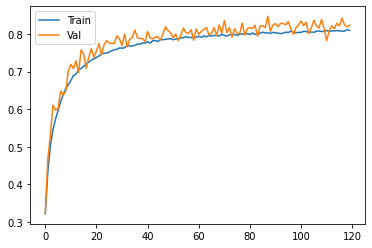

In [19]:
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

In [20]:
model2 = model

In [21]:
model2.load_weights('./mi_mejor_modelo.hdf5')

In [22]:
model2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6269 - accuracy: 0.8362


[0.6269497871398926, 0.8361999988555908]